# Project 2 - Part 2

In [1]:
pip install -r requirements.txt


[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.init as init
import math
import torch.nn.functional as F
import torch.optim as optim
import tsfresh
from torch.utils.data import DataLoader, Dataset
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from tqdm import tqdm
from sklearn.metrics import balanced_accuracy_score
import random

In [2]:
data_train = pd.read_csv('data/mitbih_train.csv')
data_test = pd.read_csv('data/mitbih_test.csv')
data_train.columns = [str(i) for i in range(len(data_train.columns)-1)] + ['label']
data_test.columns = [str(i) for i in range(len(data_test.columns)-1)] + ['label']

X_train = data_train.iloc[:, :-1]
y_train = data_train.iloc[:, -1]
X_test = data_test.iloc[:, :-1]
y_test = data_test.iloc[:, -1]

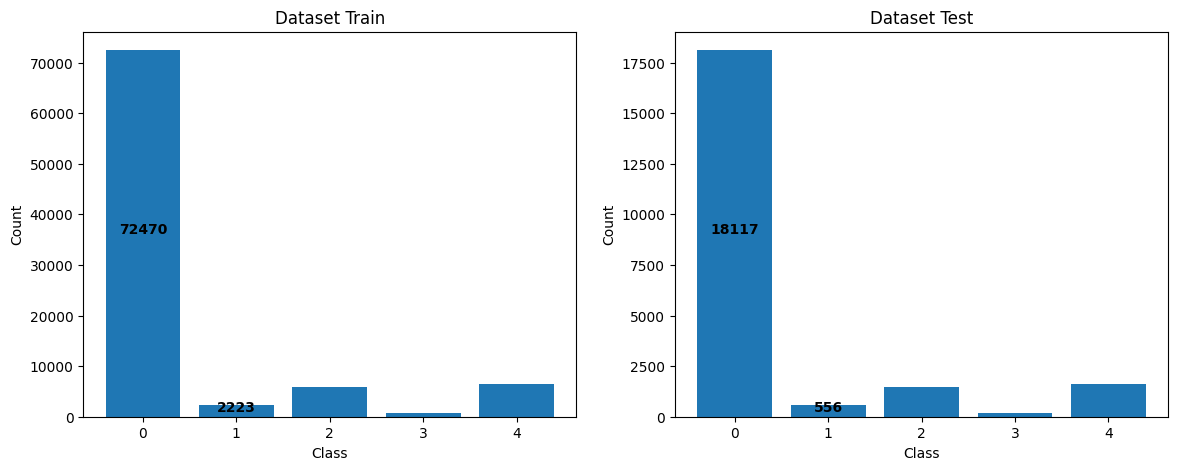

In [3]:
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

datasets = [y_train, y_test]
dataset_names = ['Train', 'Test']
for i in range(2):
    axs[i].bar(np.unique(y_train), datasets[i].value_counts().sort_index(ascending=True))
    axs[i].set_title('Dataset ' + dataset_names[i])
    axs[i].set_ylabel('Count')
    axs[i].set_xlabel('Class')
    axs[i].text(0, datasets[i].value_counts()[0]/2, datasets[i].value_counts()[0], ha='center', fontweight='bold')
    axs[i].text(1, datasets[i].value_counts()[1]/2, datasets[i].value_counts()[1], ha='center', fontweight='bold')
plt.show()


## Data preparation

In [4]:
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
print(device)

mps


In [5]:
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32).unsqueeze(2).to(device)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32).unsqueeze(2).to(device)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).to(device)

In [6]:
X_train_dataloader = DataLoader(torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor), batch_size=100, shuffle=True)
X_test_dataloader = DataLoader(torch.utils.data.TensorDataset(X_test_tensor, y_test_tensor), batch_size=100, shuffle=False)

## Supervised Model for Transfer

In [7]:
## Use balanced accuracy as metric

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=0.1)
        
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-torch.log(torch.tensor(10000.0)) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)
        
    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)
    
class TransformerModel(nn.Module):
    def __init__(self, input_dim, output_size, d_model=128, nhead=4, num_encoder_layers=3, dim_feedforward=512, dropout=0.1, max_k=20):
        super(TransformerModel, self).__init__()
        self.embedding = nn.Linear(input_dim, d_model)
        self.pos_encoder = PositionalEncoding(d_model)
        encoder_layers = nn.TransformerEncoderLayer(d_model, nhead, dim_feedforward, dropout)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_encoder_layers)
        self.fc1 = nn.Linear(d_model, d_model) 
        self.fc2 = nn.Linear(d_model, output_size)
        self.d_model = d_model

        self.W = nn.Parameter(torch.randn(max_k, d_model, d_model))
        self.z_encoder = nn.Linear(1, d_model)

    def encode(self, src):
        src = self.embedding(src.permute(0,2,1)) * math.sqrt(self.d_model)
        src = self.pos_encoder(src)
        output = self.transformer_encoder(src)
        return self.fc1(output.mean(dim=1)) # Global average pooling
        
    def forward(self, src):
        output = self.encode(src)
        output = nn.functional.relu(output)
        output = self.fc2(output) 
        # CrossEntropyLoss does not need any activation function in the output layer
        return output
    
input_size = X_train_tensor.shape[1]
output_size = len(np.unique(y_train))

In [31]:
model = TransformerModel(input_size, output_size).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)

/Users/kari/ETH/vor2324/Machine Learning in Health Care/ML4HC_project2/mlhc2/lib/python3.10/site-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [32]:
epoch_losses_training = []
epoch_losses_testing = []
epoch_accuracies_training = []
epoch_accuracies_testing = []

num_epochs = 100
pbar = tqdm(range(num_epochs))
for epoch in pbar:
    total_loss = 0
    pred_train = []
    y_train_list = []

    for i, (X_batch, y_batch) in enumerate(X_train_dataloader):
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        pred_train.append(torch.argmax(outputs, dim=1))
        y_train_list.append(y_batch)

        total_loss += loss.item() * len(X_batch)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step() 

    epoch_accuracies_training.append(balanced_accuracy_score(torch.cat(y_train_list).cpu().numpy(), torch.cat(pred_train).cpu().numpy()))
    epoch_losses_training.append(total_loss/len(X_train_tensor))
    
    with torch.no_grad():
        pred_test = []
        y_test_list = []
        total_loss_test = 0
        for i, (X_batch, y_batch) in enumerate(X_test_dataloader):
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            pred_test.append(torch.argmax(outputs, dim=1))
            y_test_list.append(y_batch)

            total_loss += loss.item() * len(X_batch)
        
        epoch_accuracies_testing.append(balanced_accuracy_score(torch.cat(y_test_list).cpu().numpy(), torch.cat(pred_test).cpu().numpy()))
        epoch_losses_testing.append(total_loss/len(X_test_tensor))

        pbar.set_description(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_losses_training[-1]:.4f}, Balanced Accuracy: {epoch_accuracies_training[-1]:.4f}, test loss: {epoch_losses_testing[-1]:.4f}, test balanced accuracy: {epoch_accuracies_testing[-1]:.4f}')

Epoch [100/100], Loss: 0.0213, Balanced Accuracy: 0.9424, test loss: 0.2433, test balanced accuracy: 0.7741: 100%|██████████| 100/100 [35:33<00:00, 21.34s/it]


In [33]:
torch.save(model.state_dict(), './p2/transformer_100_lr_3e-4_1_hidden')

In [34]:
with torch.no_grad():
    acc_test = []
    test_outputs = []
    total_loss_test = 0
    for i, (X_batch, y_batch) in enumerate(X_test_dataloader):
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        pred = torch.argmax(outputs, dim=1)
        acc_test.append(pred == y_batch)
        test_outputs.append(pred)

        total_loss_test += loss.item() * len(X_batch)

    print(f'Test set Accuracy: {torch.cat(acc_test).cpu().float().mean():.4f}, Loss: {total_loss_test/len(X_test_tensor)}, Balanced Accuracy: {balanced_accuracy_score(y_test_tensor.int().cpu().numpy(), torch.cat(test_outputs).cpu().numpy()):.4f}')

Test set Accuracy: 0.9667, Loss: 0.16026083056823562, Balanced Accuracy: 0.7701


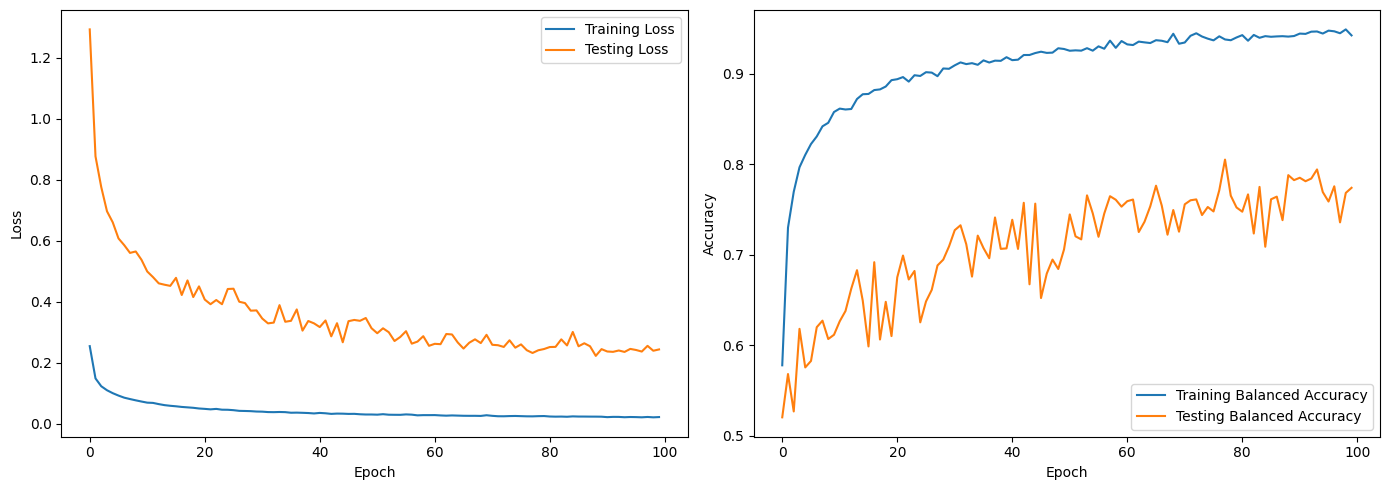

In [35]:
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# Plotting the losses
axs[0].plot(epoch_losses_training, label='Training Loss')
axs[0].plot(epoch_losses_testing, label='Testing Loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend()

# Plotting the accuracies
axs[1].plot(epoch_accuracies_training, label='Training Balanced Accuracy')
axs[1].plot(epoch_accuracies_testing, label='Testing Balanced Accuracy')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy')
axs[1].legend()

plt.tight_layout()
plt.show()

## Representation Learning Model

In [103]:
class ContrastiveModel(nn.Module):
    def __init__(self, input_size, d_model = 128, max_k = 20):
        super(ContrastiveModel, self).__init__()

        self.d_model = d_model
        
        self.encoder = TransformerModel(input_size, d_model)

        self.W = nn.Parameter(torch.randn(max_k, d_model, d_model))
        self.z_encoder = nn.Sequential(nn.Linear(1, d_model), nn.ReLU(), nn.Linear(d_model, d_model))

    def encode(self, src):
        return self.encoder(src)
        
    def forward(self, src, y_pos, y_neg, k):
        batch_size = src.shape[0]

        c = self.encoder(src)

        z_pos = self.z_encoder(y_pos.unsqueeze(1))
        z_neg = self.z_encoder(y_neg.flatten().unsqueeze(1)).view(batch_size, -1, self.d_model)
        # CrossEntropyLoss does not need any activation function in the output layer
        return c, z_pos, z_neg, self.W[k,:,:]

In [104]:
class InfoNCELoss(nn.Module):
    def __init__(self, temperature=1.0):
        super(InfoNCELoss, self).__init__()
        self.temperature = temperature

    def forward(self, c, z_pos, z_neg, W_k):
        pred_k = torch.matmul(W_k, c.permute(1,0))

        log_score_pos = torch.matmul(z_pos, pred_k).diag() / self.temperature
        log_score_neg = torch.diagonal(torch.matmul(z_neg, pred_k), dim1=0, dim2=2).permute(1,0) / self.temperature

        log_score = torch.cat([log_score_pos.unsqueeze(1), log_score_neg], dim=1)

        normalizer = torch.logsumexp(log_score, dim=1)
        
        return (-log_score_pos + normalizer).mean()

In [105]:

num_negative = 10
max_k = 20

In [106]:
def collate_fn(batch):
    X = torch.cat([item[0].unsqueeze(0) for item in batch], dim=0).squeeze(2)

    seq_lens = (X != 0).sum(dim=1)
    min_seq_len = seq_lens.min().item()

    k = torch.randint(1, min(max_k, min_seq_len), (1,)).item()

    t = [torch.randint(0, seq_len - k, (1,)).item() for seq_len in seq_lens]

    # create positive samples y, a target vector that is value t + k for each sequence
    y_pos = torch.tensor([X[i, t[i] + k] for i in range(len(t))])

    # create negative samples by sampling at random from the same sequence
    y_neg = torch.zeros(len(batch), num_negative)
    for i in range(len(t)):
        # sample 10 numbers that are not i in the range 0 to len(batch)
        neg_samples = random.sample(range(0, len(batch) - 1), num_negative)
        # remove possibility of sampling i
        neg_samples = torch.tensor([x if x < i else x + 1 for x in neg_samples])

        y_neg[i,:] = y_pos[neg_samples]

    # mask X to only keep the first t elements for each row
    for i in range(len(X)):
        X[i, t[i]:] = 0

    return X.unsqueeze(2).to(device), y_pos.to(device), y_neg.to(device), k

In [115]:
train_dataloader_nce = DataLoader(torch.utils.data.TensorDataset(X_train_tensor[:-1]), batch_size=32, collate_fn=collate_fn, shuffle=True)

In [116]:
input_size = X_train_tensor.shape[1]
d_model = 128

model = ContrastiveModel(input_size, d_model, max_k).to(device)
criterion = InfoNCELoss(temperature=0.1)
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)

/Users/kari/ETH/vor2324/Machine Learning in Health Care/ML4HC_project2/mlhc2/lib/python3.10/site-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [ ]:
epoch_losses_training = []

In [118]:

num_epochs = 100

pbar = tqdm(range(num_epochs))

for epoch in pbar:
    total_loss = 0
    pred_train = []
    y_train_list = []

    for i, (X_batch, y_pos, y_neg, k) in enumerate(train_dataloader_nce):
        c, z_pos, z_neg, W_k = model(X_batch, y_pos, y_neg, k)

        loss = criterion(c, z_pos, z_neg, W_k)

        total_loss += loss.item() * len(X_batch)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step() 

    epoch_losses_training.append(total_loss/len(X_train_tensor))
    
    with torch.no_grad():
        pbar.set_description(f'Epoch [{epoch+1}/{num_epochs}], training loss: {epoch_losses_training[-1]:.4f}')

Epoch [57/100], training loss: 1.5977:  57%|█████▋    | 57/100 [1:56:49<1:28:07, 122.98s/it]


KeyboardInterrupt: 

In [119]:
torch.save(model.state_dict(), './p2/contrastive_57')

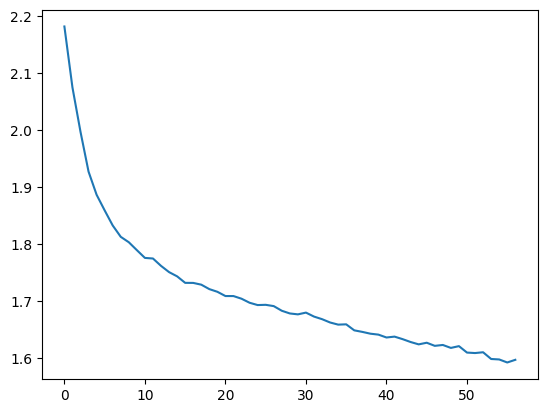

In [120]:
plt.plot(epoch_losses_training, label='Training Loss')

## Visualising Learned Representations

In [13]:
model = TransformerModel(input_size, output_size).to(device)
model.load_state_dict(torch.load('./p2/transformer_100_lr_3e-4_1_hidden'))

/Users/kari/ETH/vor2324/Machine Learning in Health Care/ML4HC_project2/mlhc2/lib/python3.10/site-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


<All keys matched successfully>

In [14]:
X_train_encoded = []
y_train_encoded = []

X_test_encoded = []
y_test_encoded = []

with torch.no_grad():
    for i, (X_batch, y_batch) in enumerate(X_train_dataloader):
        outputs = model.encode(X_batch)
        X_train_encoded.append(outputs)
        y_train_encoded.append(y_batch)
    
    for i, (X_batch, y_batch) in enumerate(X_test_dataloader):
        outputs = model.encode(X_batch)
        X_test_encoded.append(outputs)
        y_test_encoded.append(y_batch)

X_train_encoded = torch.cat(X_train_encoded).cpu().numpy()
X_test_encoded = torch.cat(X_test_encoded).cpu().numpy()

y_train_encoded = torch.cat(y_train_encoded).cpu().numpy()
y_test_encoded = torch.cat(y_test_encoded).cpu().numpy()

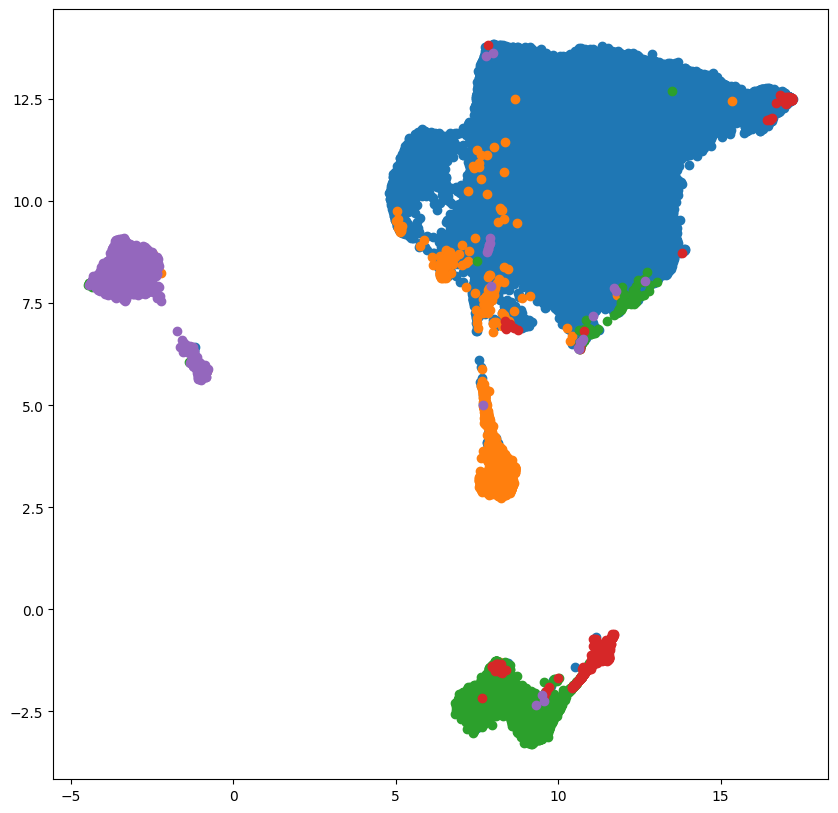

In [23]:
# UMAP for dimensionality reduction

import umap.umap_ as umap

umap_model = umap.UMAP(n_components=2)
X_train_umap = umap_model.fit_transform(X_train_encoded)

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
for i in np.unique(y_train_encoded):
    ax.scatter(X_train_umap[y_train_encoded == i, 0], X_train_umap[y_train_encoded == i, 1], label=f'Class {i}')

In [24]:
data_train = pd.read_csv('data/ptbdb_train.csv')
data_test = pd.read_csv('data/ptbdb_test.csv')
data_train.columns = [str(i) for i in range(len(data_train.columns)-1)] + ['label']
data_test.columns = [str(i) for i in range(len(data_test.columns)-1)] + ['label']

X_train_ptb = data_train.iloc[:, :-1]
y_train_ptb = data_train.iloc[:, -1]
X_test_ptb = data_test.iloc[:, :-1]
y_test_ptb = data_test.iloc[:, -1]

X_train_tensor_ptb = torch.tensor(X_train_ptb.values, dtype=torch.float32).unsqueeze(2).to(device)
y_train_tensor_ptb = torch.tensor(y_train_ptb.values, dtype=torch.float32).to(device)
X_test_tensor_ptb = torch.tensor(X_test_ptb.values, dtype=torch.float32).unsqueeze(2).to(device)
y_test_tensor_ptb = torch.tensor(y_test_ptb.values, dtype=torch.float32).to(device)

X_train_dataloader_ptb = DataLoader(torch.utils.data.TensorDataset(X_train_tensor_ptb, y_train_tensor_ptb), batch_size=100, shuffle=True)
X_test_dataloader_ptb = DataLoader(torch.utils.data.TensorDataset(X_test_tensor_ptb, y_test_tensor_ptb), batch_size=100, shuffle=False)

In [25]:
X_train_encoded_ptb = []
y_train_encoded_ptb = []
X_test_encoded_ptb = []
y_test_encoded_ptb = []

with torch.no_grad():
    for i, (X_batch, y_batch) in enumerate(X_train_dataloader_ptb):
        outputs = model.encode(X_batch)
        X_train_encoded_ptb.append(outputs)
        y_train_encoded_ptb.append(y_batch)
    
    for i, (X_batch, y_batch) in enumerate(X_test_dataloader_ptb):
        outputs = model.encode(X_batch)
        X_test_encoded_ptb.append(outputs)
        y_test_encoded_ptb.append(y_batch)

X_train_encoded_ptb = torch.cat(X_train_encoded_ptb).cpu().numpy()
X_test_encoded_ptb = torch.cat(X_test_encoded_ptb).cpu().numpy()

y_train_encoded_ptb = torch.cat(y_train_encoded_ptb).cpu().numpy()
y_test_encoded_ptb = torch.cat(y_test_encoded_ptb).cpu().numpy()

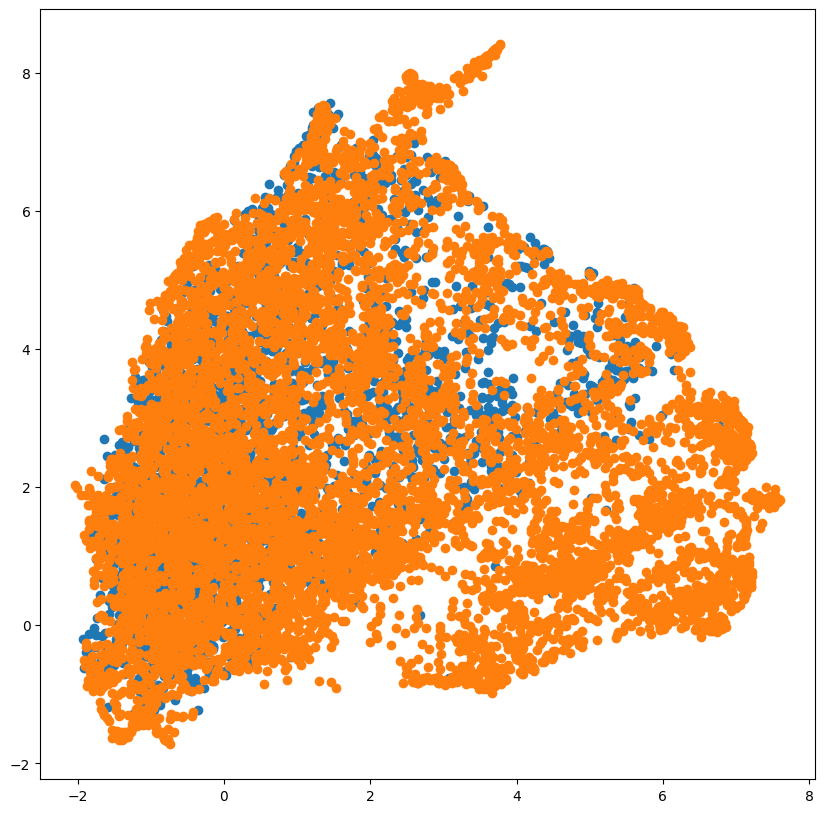

In [27]:
umap_model = umap.UMAP(n_components=2)
X_train_umap = umap_model.fit_transform(X_train_encoded_ptb)

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
for i in np.unique(y_train_encoded_ptb):
    ax.scatter(X_train_umap[y_train_encoded_ptb == i, 0], X_train_umap[y_train_encoded_ptb == i, 1], label=f'Class {i}')

## Finetuning Strategies

### Classic ML models
For simplicity, only logistic regression for now

In [28]:
logistic = LogisticRegression(max_iter=1000)

logistic.fit(X_train_encoded, y_train_encoded)

y_pred = logistic.predict(X_test_encoded)
print(f'Test set balanced accuracy: {balanced_accuracy_score(y_test_encoded, y_pred):.4f}')

Test set balanced accuracy: 0.7953


In [29]:
logistic = LogisticRegression(max_iter=1000)

logistic.fit(X_train_encoded_ptb, y_train_encoded_ptb)

y_pred = logistic.predict(X_test_encoded_ptb)
print(f'Test set balanced accuracy: {balanced_accuracy_score(y_test_encoded_ptb, y_pred):.4f}')

Test set balanced accuracy: 0.6952


### Fine-tune output layer only

### Fine-tune output layer, then fine-tune full model